# This is an example of using the output of a logistic regression classifier as the collective variable for acclerated sampling. 

## It follows after the 01-SVM_example so please consider reading through that before this

In [1]:
import msmexplorer as msme
import numpy as np
%pylab inline
import seaborn as sns 
sns.set_style("whitegrid")
sns.set_context("talk",1.3)
from msmbuilder.utils import load

Populating the interactive namespace from numpy and matplotlib


/Users/muneeb/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/muneeb/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
plot_feat = load("./train_data/raw_features.pkl")
train_feat = load("./train_data/features.pkl")

In [3]:
df = load("./train_data/feature_descriptor.pkl")

In [4]:
df

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[4, 6, 8, 14]",phi,Dihedral,sin,"[0, 1]","[ALA, ACE]","[1, 2]"
1,"[4, 6, 8, 14]",phi,Dihedral,cos,"[0, 1]","[ALA, ACE]","[1, 2]"
2,"[6, 8, 14, 16]",psi,Dihedral,sin,"[1, 2]","[ALA, NME]","[2, 3]"
3,"[6, 8, 14, 16]",psi,Dihedral,cos,"[1, 2]","[ALA, NME]","[2, 3]"


(-3.141592653589793, 3.141592653589793)

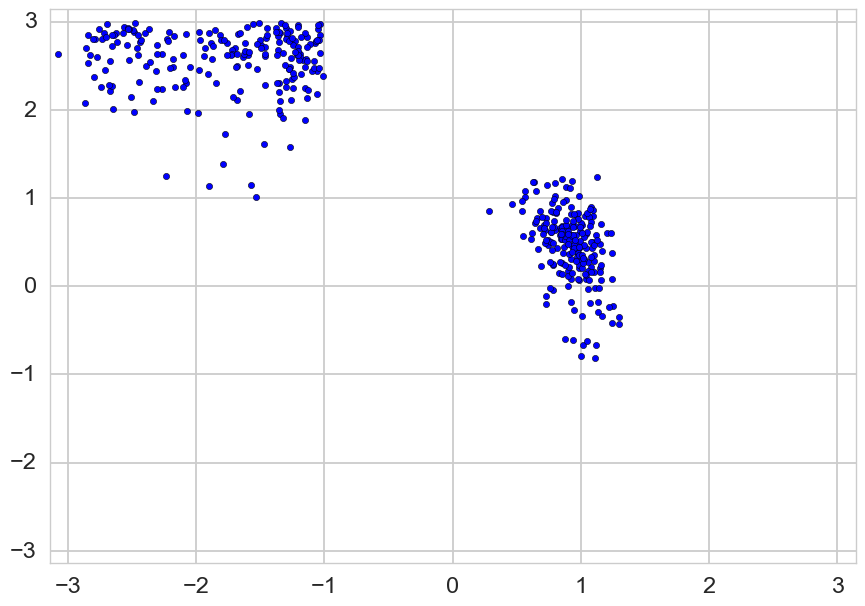

In [5]:
scatter(np.vstack(plot_feat)[:,0],np.vstack(plot_feat)[:,1])
xlim([-pi,pi])
ylim([-pi,pi])

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
import os

In [88]:
X=np.vstack(plot_feat)
train_X=np.vstack(train_feat)

train_Y=np.concatenate([np.zeros(len(plot_feat[0])),
            np.ones(len(plot_feat[0]))])
if not os.path.isfile("./lr_model_2.pkl"):
    train =True 
else:
    clf = load("./lr_model_2.pkl")
    train =False
if train:
    clf = LogisticRegression(penalty="l1",C=100)
    clf.fit(train_X, train_Y)


In [89]:
if train:
    from msmbuilder.utils import dump
    dump(clf,"./lr_model_2.pkl")

In [90]:
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# The predicited probabilites from our LR is the collective variable that we will sample. 

In [91]:
lr_cv = b=clf.predict_proba(train_X)

In [92]:
nx =ny=50
lim_x = lim_y = np.linspace(-pi,pi,nx)
xv, yv = np.meshgrid(lim_x, lim_y, sparse=False, indexing='ij')
res = []
for i in range(nx):
    for j in range(ny):
        X_val = np.array([np.sin(xv[i,j]),np.cos(xv[i,j]), np.sin(yv[i,j]), np.cos(yv[i,j])]).reshape(1,-1)
        res.extend(clf.predict(X_val))
#contourf(lim_x,lim_y,np.array(res).reshape(10,10),cmap='coolwarm')


/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


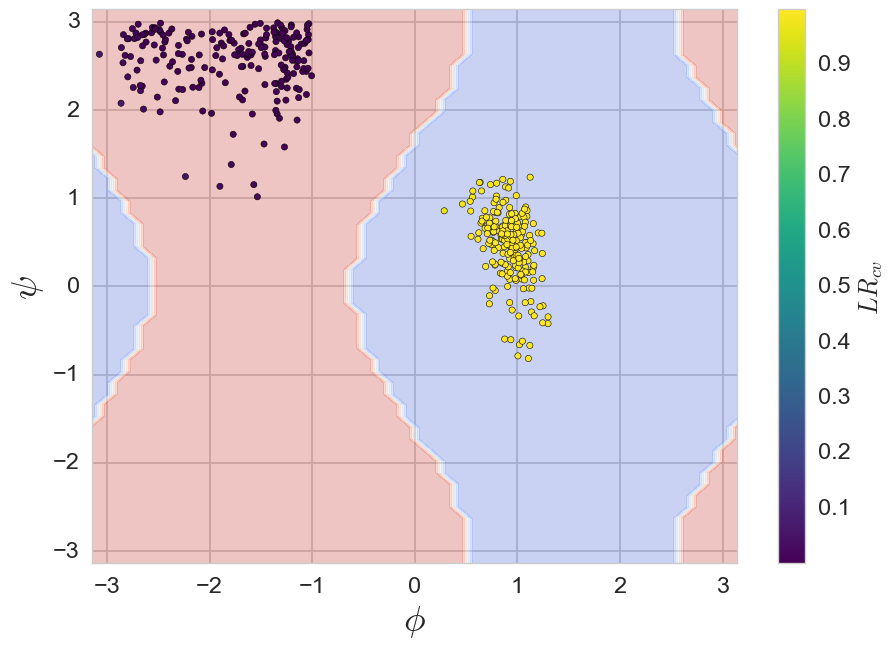

In [93]:
contourf(lim_x,lim_y,np.array(res).reshape(nx,ny).T,cmap="coolwarm",alpha=0.3)
p=scatter(np.vstack(plot_feat)[:,0],np.vstack(plot_feat)[:,1],
       c=clf.predict_proba(train_X)[:,0],cmap='viridis')
xlim([-pi,pi])
ylim([-pi,pi])
cb=colorbar(p)
cb.set_label(r'$LR_{cv}$')
ylabel(r'$\psi$',size=26)
xlabel(r'$\phi$',size=26)

# We can again examine what the model is learning 

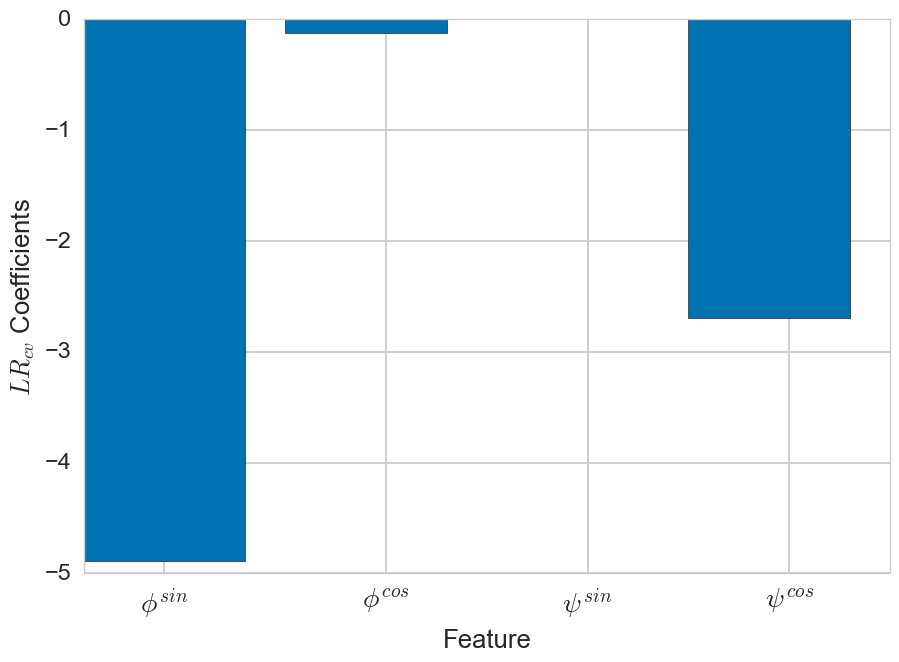

In [94]:
bar([0,1,2,3],clf.coef_[0],color=sns.color_palette("colorblind")[0])
xticks([0.4,1.5,2.5,3.5],[r'$\phi^{sin}$',r'$\phi^{cos}$',r'$\psi^{sin}$',r'$\psi^{cos}$'],size=20)
xlabel("Feature")
ylabel(r'$LR_{cv}$ Coefficients')



# To sample the LR's decision function we again need Plumed, OpenMM and the tica_metadynamics repo from my github

In [95]:
from sklearn.utils.validation import check_is_fitted

In [96]:
from tica_metadynamics.pyplumed import render_df
from tica_metadynamics.pyplumed import render_meta 
from jinja2 import Template

In [97]:
plumed_matheval_template = Template("MATHEVAL ARG={{arg}} FUNC={{func}} LABEL={{label}} PERIODIC={{periodic}} ")

plumed_combine_template = Template("COMBINE LABEL={{label}} ARG={{arg}} COEFFICIENTS={{coefficients}} "+\
                                    "PERIODIC={{periodic}} ")

# The function below will teach Plumed how to compute a distance to an LR's decision function/predicted output probabilities.

In [98]:
def render_lr(clf=None, input_prefix="f0", output_prefix="l"):
    if clf is None or check_is_fitted(clf,attributes=["coef_","intercept_"]):
        raise ValueError("Need a fitted Sklearn Logistic Regression object")
    else:
        n_args = clf.coef_.shape[1]
        output = []
        arg_list=",".join(["%s_%d"%(input_prefix,i) for i in range(n_args)])
        coeff = ",".join([str(i) for i in clf.coef_[0]])
        w_norm = 1.0 
        
        output.append(plumed_combine_template.render(label="%s_0"%output_prefix,
                                      arg=arg_list,
                                      coefficients=coeff,
                                      periodic="NO")+"\n")
        
        func="1/(1+exp(-(x+%s)))"%(str(clf.intercept_[0]))
        
        output.append(plumed_matheval_template.render(label="%s_1"%output_prefix,
                                      arg="l_0",
                                      func=func,
                                      periodic="NO")+"\n")        
        
    return ''.join(output)
        
        

In [100]:
b=clf.predict_proba(train_X)
np.std(b[300:,0])

0.009481061048778187

In [35]:
total_out=[]
total_out.extend("RESTART\n")
total_out.extend(render_df(df))
total_out.extend(render_lr(clf))
total_out.extend(render_meta.render_metad_code("l_1",biasfactor=8,sigma=0.05))
total_out.extend(render_meta.render_metad_bias_print("l_1,metad.bias"))

In [36]:
print("".join(total_out))

RESTART
TORSION ATOMS=5,7,9,15 LABEL=phi_0_1 

TORSION ATOMS=7,9,15,17 LABEL=psi_1_2 

MATHEVAL ARG=phi_0_1 FUNC=sin(x) LABEL=f0_0 PERIODIC=NO 

MATHEVAL ARG=phi_0_1 FUNC=cos(x) LABEL=f0_1 PERIODIC=NO 

MATHEVAL ARG=psi_1_2 FUNC=sin(x) LABEL=f0_2 PERIODIC=NO 

MATHEVAL ARG=psi_1_2 FUNC=cos(x) LABEL=f0_3 PERIODIC=NO 

COMBINE LABEL=l_0 ARG=f0_0,f0_1,f0_2,f0_3 COEFFICIENTS=-4.89125655098,-0.126680058129,0.0,-2.69896958546 PERIODIC=NO 
MATHEVAL ARG=l_0 FUNC=1/(1+exp(-(x+0.0))) LABEL=l_1 PERIODIC=NO 
METAD ARG=l_1 SIGMA=0.05 HEIGHT=1.0 FILE=HILLS TEMP=300 PACE=1000 LABEL=metad BIASFACTOR=8
PRINT ARG=l_1,metad.bias STRIDE=1000 FILE=BIAS 


In [26]:
# Again, we can analyze the results after running simulations elsewhere

In [41]:
import mdtraj as md
from msmbuilder.featurizer import DihedralFeaturizer

In [112]:
test_traj = md.load("./lr_meta_traj_lowc/reweight//trajectory.dcd",top="./0.pdb")
feat = load("./train_data//featurizer.pkl")
bias = np.loadtxt("./lr_meta_traj_lowc/reweight//BIAS")

In [113]:
test_feat = feat.transform([test_traj])[0]
plot_test_feat = DihedralFeaturizer(sincos=False).transform([test_traj])[0]

In [114]:
clf = load("./lr_model_2.pkl")

In [115]:
test_feat

array([[-0.66600692, -0.74594557,  0.28042728, -0.95987529],
       [ 0.64974892,  0.76014894,  0.89131576,  0.45338309],
       [ 0.83231139,  0.5543083 ,  0.62151057,  0.78340578],
       ..., 
       [-0.52911538, -0.8485499 ,  0.08035588,  0.99676621],
       [-0.47606608, -0.87940949, -0.04617105,  0.99893355],
       [-0.42987618, -0.90288782,  0.34432283,  0.9388513 ]], dtype=float32)

In [116]:
clf_out = clf.predict_proba(test_feat)

In [117]:
clf_out

array([[ 0.00261785,  0.99738215],
       [ 0.98899186,  0.01100814],
       [ 0.99808411,  0.00191589],
       ..., 
       [ 0.49867707,  0.50132293],
       [ 0.56368381,  0.43631619],
       [ 0.57857309,  0.42142691]])

# Making sure that Sklearn and Plumed are computing the same value


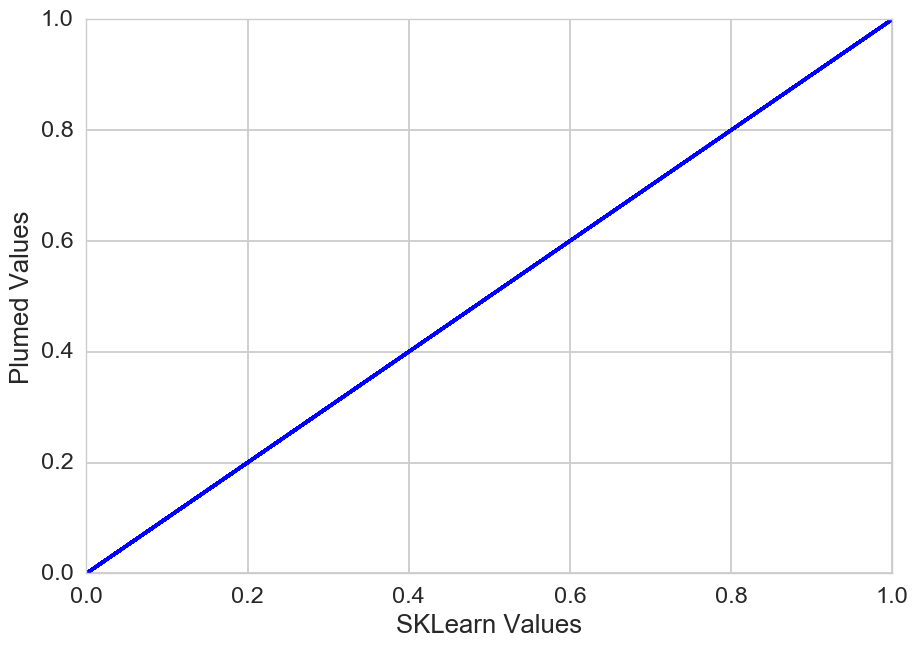

In [118]:
plot(clf.predict_proba(test_feat)[:,1],bias[:,1])
xlabel("SKLearn Values")
ylabel("Plumed Values")

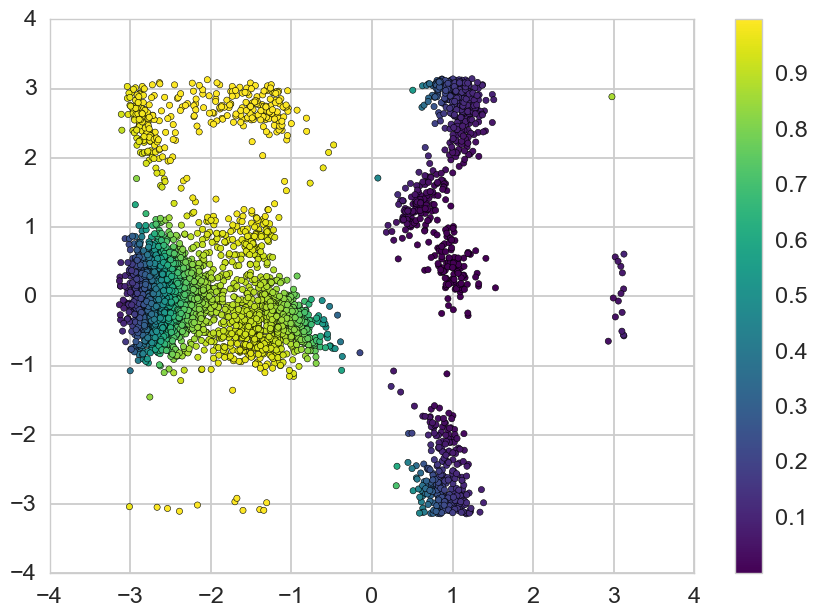

In [119]:
scatter(plot_test_feat[:,0],plot_test_feat[:,1],c=clf_out[:,1],cmap='viridis')
colorbar()

# We can analyze this in terms of plotting the trajectories

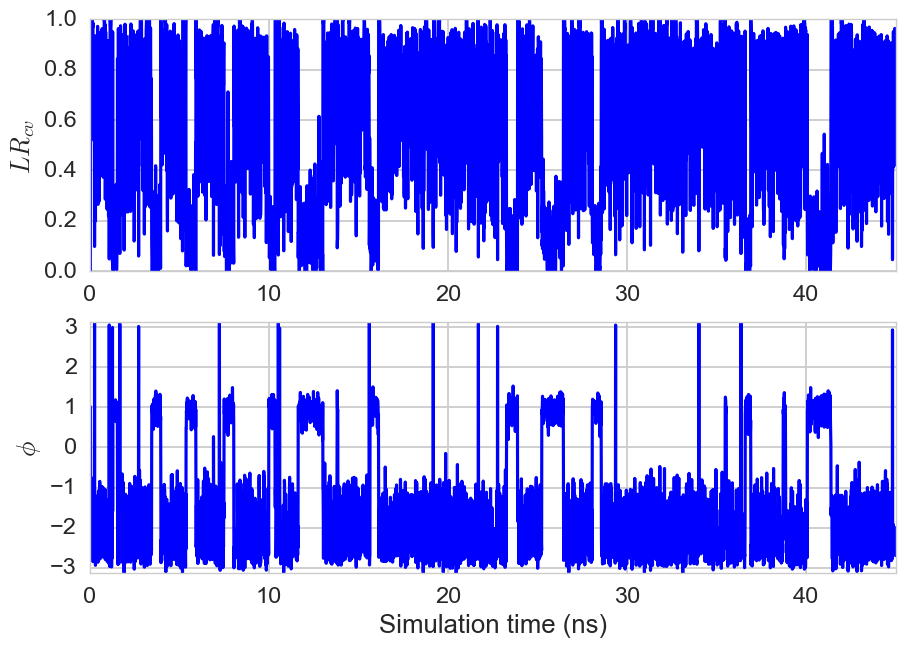

In [120]:
subplot(2,1,1)
plot(bias[:,1])
xticks([0,1000,2000,3000,4000],[0,10,20,30,40])
ylabel(r'$LR_{cv}$')

subplot(2,1,2)
plot(plot_test_feat[:,0])
xticks([0,1000,2000,3000,4000],[0,10,20,30,40])
xlabel("Simulation time (ns)")
ylim([-pi,pi])
ylabel(r'$\phi$')

In [121]:
# Or do some basic re-weighting using Tiwary's algorithm 

/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


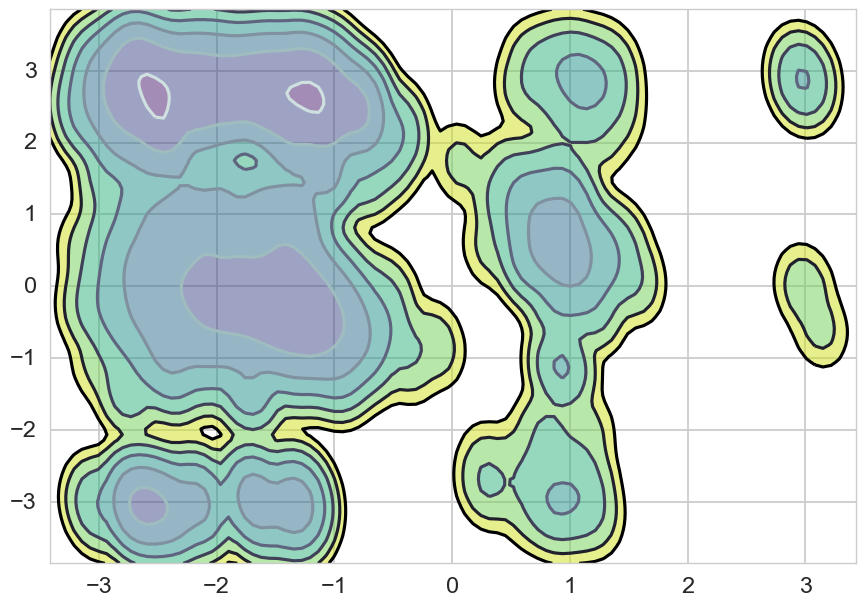

In [122]:
ax,data=msme.plot_free_energy(plot_test_feat,obs=[0,1],n_samples=100000,pi=np.exp(bias[:,-1]/2.49),
                      cmap='viridis',gridsize=100,vmin=-1,vmax=7,n_levels=8,return_data=True)

/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-3.141592653589793, 3.141592653589793)

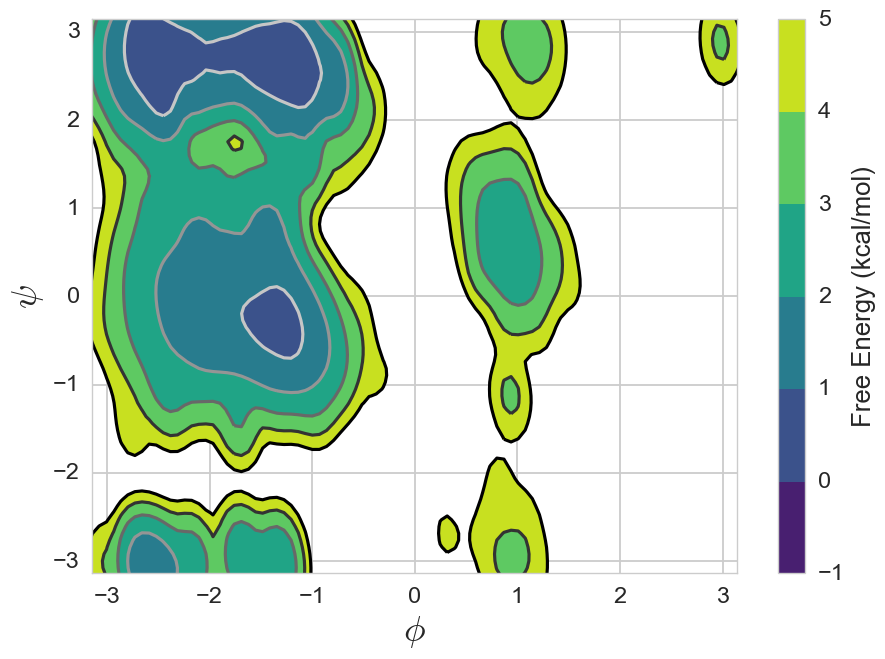

In [123]:
offset = data[2].min(0)
contour(data[0],data[1],data[2],levels=np.linspace(-1,5,7))
p=contourf(data[0],data[1],data[2],levels=np.linspace(-1,5,7),cmap='viridis')
cb=colorbar(p)
cb.set_label("Free Energy (kcal/mol)")
xlabel(r'$\phi$',size=26)
ylabel(r'$\psi$',size=26)
xlim([-pi,pi])
ylim([-pi,pi])


In [41]:
# These are from the scikit learn website and were used to make parts of figure 1 

In [42]:
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
tmp_x = [xx[0],yy[0]]
b=np.dot(clf.coef_,tmp_x)+clf.intercept_/np.linalg.norm(clf.coef_)
print(b)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()


NameError: name 'svm' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

# this is our test set, it's just a straight line with some
# Gaussian noise
xmin, xmax = -5, 5
n_samples = 100
np.random.seed(0)
X = np.random.normal(size=n_samples)
y = (X > 0).astype(np.float)
X[X > 0] *= 4
X += .3 * np.random.normal(size=n_samples)

X = X[:, np.newaxis]
# run the classifier
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(X, y)

# and plot the result
plt.figure(1)
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
X_test = np.linspace(-5, 10, 300)


def model(x):
    return 1 / (1 + np.exp(-x))
loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss,linestyle='dashed', linewidth=1,label="Logistic Regression")


plt.xlabel('Feature 1')
plt.ylabel('Probability Ouput')
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)
plt.legend(loc="lower right", fontsize='small')
plt.show()
